<a href="https://colab.research.google.com/github/bori00/BrainTumorClassification/blob/bori_dev/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Setup

In [127]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import urllib
from urllib import request

import time

from numpy.random import seed

In [2]:
pip install -U matplotlib

In [130]:
# Reproducability
SEED = 31415
def set_seed(seed_value=SEED):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    seed(seed_value)
set_seed()

## Import Dataset

In [4]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# unzip the files containing the training and testing images
# important: this step assumes that you have the two zip files in 'BrainTumorClassification/Training.zip' and 'BrainTumorClassification/Testing.zip' in your Google Drive
!unzip gdrive/My\ Drive/BrainTumorClassification/Training.zip
!unzip gdrive/My\ Drive/BrainTumorClassification/Testing.zip

## Create Dataframes

Not all images ae of the same size, but 5012x512 is close to their original size.

In [6]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  validation_split=0.2,
  subset="training",
  color_mode="grayscale",
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  color_mode="grayscale",
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'Testing',
  shuffle=True,
  seed=SEED,
  color_mode="grayscale",
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [8]:
for x, y in train_ds.take(1):
  print("Shape of one batch in the   training dataset: ", x.shape, " with labels:", y)

for x, y in valid_ds.take(1):
  print("Shape of one batch in the validation dataset: ", x.shape, " with labels:", y)

for x, y in test_ds.take(1):
  print("Shape of one batch in the    testing dataset: ", x.shape, " with labels:", y)

Shape of one batch in the   training dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 1 1 2 1 0 1 1 3 0 1 2 1 3 3 3 0 2 3 3 3 1 2 2 3 1 3 0 1 3 3 0], shape=(32,), dtype=int32)
Shape of one batch in the validation dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 1 0 1 3 3 1 0 2 1 2 0 2 1 0 1 0 3 3 0 3 2 1 0 1 1 0 2 3 3 0 3], shape=(32,), dtype=int32)
Shape of one batch in the    testing dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 3 1 0 2 0 2 2 3 1 2 1 2 0 2 1 2 1 2 0 2 0 1 0 1 1 2 3 1 1 2 3], shape=(32,), dtype=int32)


In [9]:
class_names = train_ds.class_names
print("Class Names: ", class_names)

Class Names:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


### Distributions

In [10]:
def get_distribution(ds):
  vals = np.unique(np.fromiter(ds.unbatch().map(lambda x, y: y), float), return_counts=True)
  dist = [0, 0, 0, 0]

  for val, count in zip(*vals):
    dist[int(val)] = count
  
  return dist

In [11]:
training_dist = get_distribution(train_ds)
valid_dist = get_distribution(valid_ds)
testing_dist = get_distribution(test_ds)

In [12]:
training_dist

[667, 653, 305, 671]

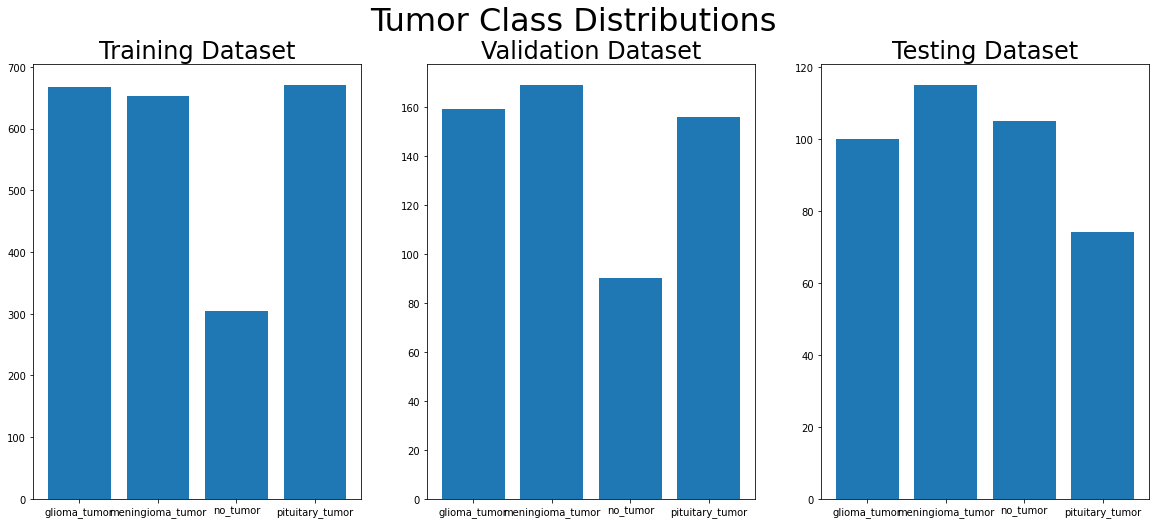

In [13]:
plt.figure(figsize=(20, 8))
plt.suptitle("Tumor Class Distributions", fontsize = 32)

plt.subplot(1, 3, 1)
plt.title("Training Dataset", fontsize = 24)
plt.bar(range(len(training_dist)), training_dist, tick_label=class_names)

plt.subplot(1, 3, 2)
plt.title("Validation Dataset", fontsize = 24)
plt.bar(range(len(valid_dist)), valid_dist, tick_label=class_names)

plt.subplot(1, 3, 3)
plt.title("Testing Dataset", fontsize = 24)
plt.bar(range(len(testing_dist)), testing_dist, tick_label=class_names)

plt.show()

The training and validation dataset are well-balanced, as they were programatically generated, but the test dataset, downloaded from kaggle, has a significantly different class distribution from that of the other datasets: the no_tumor class is overrepresented in the test dataset compared to the other two.

## Visualize data

In [14]:
def categorize_images(batch):
  cardinalities = [0, 0, 0, 0]
  cat_images = [[], [], [], []]

  for images, labels in batch:
    for i in range(images.shape[0]):
        category = int(labels[i])
        cardinalities[category] = cardinalities[category] + 1
        cat_images[category].append(images[i].numpy().astype("uint8"))
  
  return cat_images, cardinalities

In [15]:
def visualize_batch_per_categories(batch):
  cat_images, cardinalities = categorize_images(batch)

  no_columns = max(cardinalities)

  # create 4x1 subplots
  fig, axs = plt.subplots(nrows=4, ncols=1, constrained_layout=True)
  fig.set_figheight(20)
  fig.set_figwidth(4 * no_columns)
  fig.suptitle('The content of one Batch', fontsize = 64)

  # clear subplots
  for ax in axs:
      ax.remove()

  # add subfigure per subplot
  gridspec = axs[0].get_subplotspec().get_gridspec()
  subfigs = [fig.add_subfigure(gs) for gs in gridspec]

  for row, subfig in enumerate(subfigs):
      subfig.suptitle(class_names[row], fontsize = 32)

      # create 1x3 subplots per subfig
      axs = subfig.subplots(nrows=1, ncols=no_columns)
      for col, ax in enumerate(axs):
          if (cardinalities[row] > col):
            ax.plot()
            ax.imshow(cat_images[row][col-1], cmap="gray")

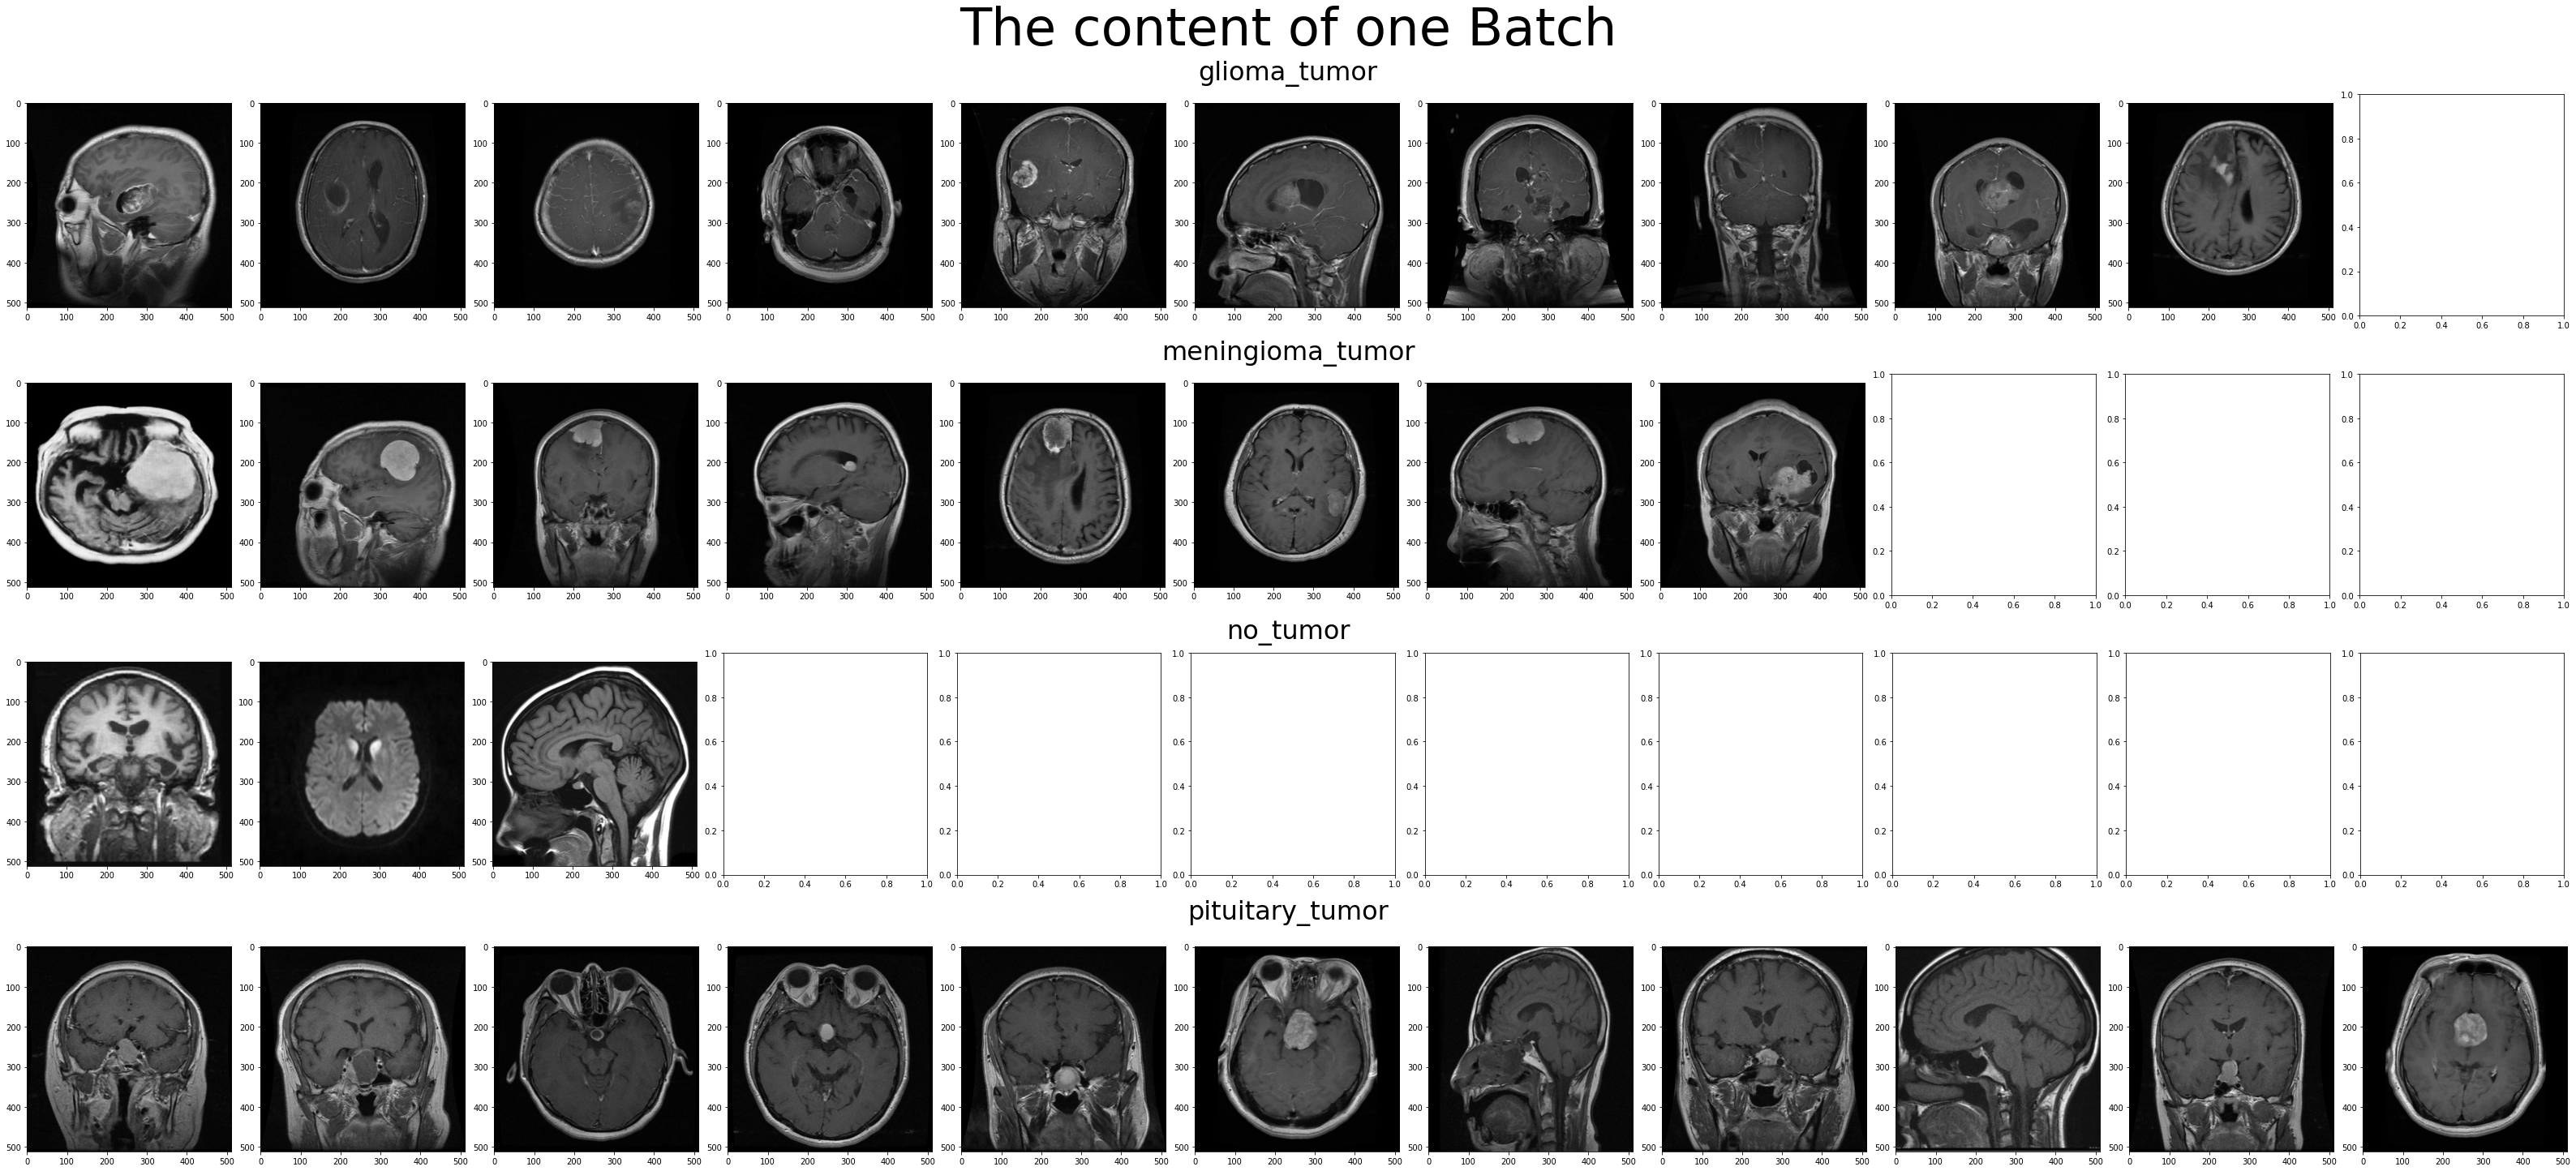

In [16]:
visualize_batch_per_categories(train_ds.take(1))

## Performance configurations

Source: [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/classification)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocessing

Let's find the range of the color intensities:

In [18]:
def get_sample_image_values_range(ds):
  image_batch, labels_batch = next(iter(ds))
  first_image = image_batch[0]
  # Notice the pixel values are now in `[0,1]`.
  return np.min(first_image), np.max(first_image)

In [19]:
print("Sample image's values' range: ", get_sample_image_values_range(train_ds))

Sample image's values' range:  (0.0, 255.0)


Because neural networks work better with small values, we should scale the [0, 255] pixel color values to [0, 1]. 

In [20]:
def rescale_pixels(ds):
  rescaler = tf.keras.layers.Rescaling(1./255.0)
  return ds.map(lambda x, y: (rescaler(x), y))

In [21]:
train_ds = rescale_pixels(train_ds)
valid_ds = rescale_pixels(valid_ds)
test_ds = rescale_pixels(test_ds)

## Creating a model

### Helper functions

In [22]:
def plot_loss_accuracy_history(history):
  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(pd.DataFrame(history.history['accuracy']))
  plt.plot(pd.DataFrame(history.history['val_accuracy']))
  plt.grid(True)
  plt.title("Accuracy")
  plt.gca().legend(('training accuracy', 'validation accuracy'))

  plt.subplot(1, 2, 2)
  plt.plot(pd.DataFrame(history.history['loss']))
  plt.plot(pd.DataFrame(history.history['val_loss']))
  plt.grid(True)
  plt.title("Loss")
  plt.gca().legend(('training loss', 'validation loss'))
  plt.show()

In [23]:
def get_images_labels_from_ds(ds):
  images = np.concatenate([x for x, y in valid_ds], axis=0)
  labels = np.concatenate([y for x, y in valid_ds], axis=0)
  return images, labels

In [60]:
def get_label_predictions(images, model):
  pred_raw = model.predict(images)
  pred_prob = tf.nn.softmax(pred_raw)
  pred_class = [np.int64(np.argmax(prob)) for prob in pred_prob]
  return pred_class

In [25]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  conf_mat = confusion_matrix(y_true, y_pred)
  cm_df = pd.DataFrame(conf_mat,
                     index = class_names, 
                     columns = class_names)
  plt.figure(figsize=(8,6))
  g = sns.heatmap(cm_df, annot=True, fmt='.4g')
  plt.title(title, fontsize=18)
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  # g.set_yticklabels(g.get_yticklabels(), rotation = 30, fontsize = 12)
  g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
  plt.show()

In [117]:
def print_classification_metrics(y_true, y_pred):
  print(classification_report(y_true, y_pred, target_names=class_names))

In [118]:
def show_full_classification_report(model, ds, model_name):
  x_images, y_true = get_images_labels_from_ds(ds)
  y_pred = get_label_predictions(x_images, model)
  plot_confusion_matrix(y_true, y_pred, "Confusion matrix for the " + model_name)
  print_classification_metrics(y_true, y_pred)

In [26]:
num_classes = len(class_names)

In [27]:
valid_images, valid_labels = get_images_labels_from_ds(valid_ds)

### Initial Model

In [123]:
model1 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_18 (Dense)            (None, 32)                33554464  
                                                                 
 dense_19 (Dense)            (None, 4)                 132       
                                                                 
Total params: 33,554,756
Trainable params: 33,554,756
Non-trainable params: 0
__________________________________________

In [124]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('initial_model.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history1 = model1.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 21s 286ms/step - loss: 4.1044 - accuracy: 0.5440 - val_loss: 0.8502 - val_accuracy: 0.7247
Epoch 2/30
72/72 [==============================] - 20s 283ms/step - loss: 0.3867 - accuracy: 0.8541 - val_loss: 0.4657 - val_accuracy: 0.8084
Epoch 3/30
72/72 [==============================] - 20s 279ms/step - loss: 0.1497 - accuracy: 0.9560 - val_loss: 0.3976 - val_accuracy: 0.8502
Epoch 4/30
72/72 [==============================] - 20s 280ms/step - loss: 0.0658 - accuracy: 0.9869 - val_loss: 0.3766 - val_accuracy: 0.8693
Epoch 5/30
72/72 [==============================] - 20s 281ms/step - loss: 0.0323 - accuracy: 0.9961 - val_loss: 0.3944 - val_accuracy: 0.8484
Epoch 6/30
72/72 [==============================] - 20s 281ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.3918 - val_accuracy: 0.8432
Epoch 7/30
72/72 [==============================] - 21s 286ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.3999 - val_accuracy: 0.8502

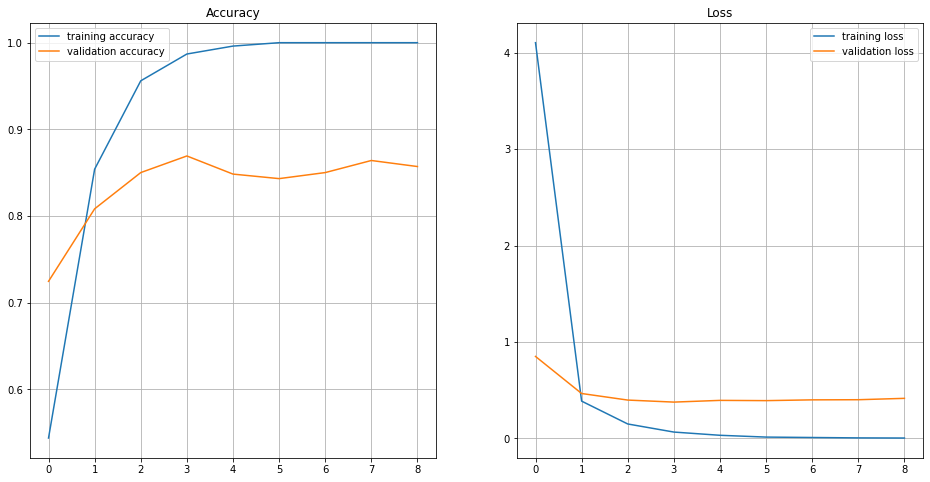

In [125]:
plot_loss_accuracy_history(history1)

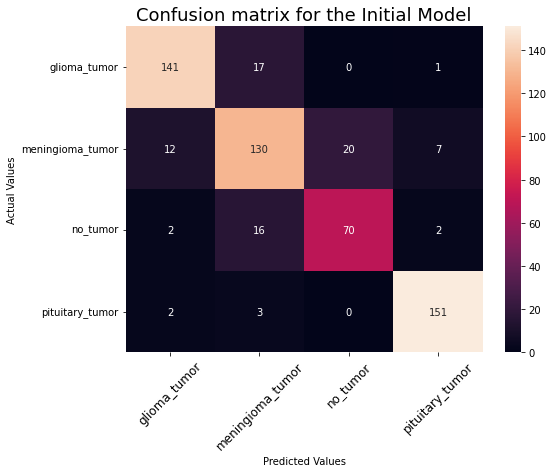

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.89      0.89       159
meningioma_tumor       0.78      0.77      0.78       169
        no_tumor       0.78      0.78      0.78        90
 pituitary_tumor       0.94      0.97      0.95       156

        accuracy                           0.86       574
       macro avg       0.85      0.85      0.85       574
    weighted avg       0.86      0.86      0.86       574



In [126]:
show_full_classification_report(model1, valid_ds, "Initial Model")